In [1]:
import numpy as np
import torch 
import torchvision 
import torchaudio
import torch.nn as nn
import math
import torch.nn.functional as F
from Jaguas_DataLoader import SoundscapeData
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import random_split
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer, PositionalEncodingPermute2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install wandb --upgrade
!wandb login
import wandb
from IPython.display import clear_output
import datetime
wandb.login()
import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)
import torch, gc
gc.collect()
torch.cuda.empty_cache()

wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


In [2]:
import torch
import torch.nn as nn
import math

# Define el modelo del encoder
class Encoder(nn.Module):
    def __init__(self, num_hiddens=64, emb_size=5184):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, num_hiddens//8, kernel_size=8, stride=3, padding=0)
        self.conv2 = nn.Conv2d(num_hiddens//8, num_hiddens//4, kernel_size=8, stride=3, padding=0)
        self.conv3 = nn.Conv2d(num_hiddens//4, num_hiddens//2, kernel_size=4, stride=3, padding=0)
        self.conv4 = nn.Conv2d(num_hiddens//2, num_hiddens, kernel_size=2, stride=2, padding=0)
#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(5184, emb_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
#         x = self.pool(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc(x)
        return x

# Define el modelo del decoder
class Decoder(nn.Module):
    def __init__(self, num_hiddens=64, emb_size=5184):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(emb_size, 5184)
        self.conv1 = nn.ConvTranspose2d(num_hiddens, num_hiddens//2, kernel_size=2, stride= 2, padding=0, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//4, kernel_size=4, stride=3, padding=0, output_padding=0)
        self.conv3 = nn.ConvTranspose2d(num_hiddens//4, num_hiddens//8, kernel_size=8, stride=3, padding=0, output_padding=0)
        self.conv4 = nn.ConvTranspose2d(num_hiddens//8, 1, kernel_size=8, stride=3, padding=0, output_padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = x.view(x.size(0), 64, 9, 9)
        print("view ",x.shape)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.sigmoid(self.conv4(x))
        return x

# Define la capa de positional encoding
class PositionalEncoding(nn.Module):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    def __init__(self, d_model, length):
        super().__init__()

        if d_model % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                             "odd dim (got dim={:d})".format(d_model))
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                             -(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x, label):
        """
        x: input tensor of shape (batch_size, emb_size)
        label: external label tensor of shape (batch_size,)
        """
        x = x.to("cuda")
        print(x.shape)
        print("pe",self.pe.shape)
        pos_enc = self.pe
        pos_enc = pos_enc.to("cuda")
        return x + pos_enc

# Define el modelo completo del autoencoder
class Autoencoder(nn.Module):
    def __init__(self, num_hiddens=64, emb_size=5184, max_seq_len=24):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(num_hiddens, emb_size)
        self.decoder = Decoder(num_hiddens, emb_size)
        self.pos_encoder = PositionalEncoding(5184, max_seq_len)

    def forward(self, x, label):
        print(f"label: {label.shape}")
        emb = self.encoder(x)
        print(f"emb: {emb.shape}")
        emb_pos_enc = self.pos_encoder(emb, label)
#         emb_pos_enc = emb_pos_enc.permute(1,0,2,3)
        print(f"embedding: {emb_pos_enc.shape}")
        recon = self.decoder(emb_pos_enc)
        return recon


In [ ]:
model = Autoencoder(num_hiddens=config["num_hiddens"], max_seq_len=70).to("cuda")
model.to("cuda")
a = model(data.to("cuda"), label["recorder"].reshape(data.shape[0]))

In [3]:
root_path = 'media/mirp_ai/DATA1/Jaguas_2018'
dataset = SoundscapeData(root_path, audio_length=12, ext="wav", win_length=1028)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "CGPTpositionalAE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Jaguas",
    "architecture": "CGPT_PositionalAE",
    "win_length" : dataset.win_length
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = Autoencoder(num_hiddens=config["num_hiddens"], max_seq_len=70).to("cuda")

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/DATA1/Jaguas_2018


In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
class TestModel:
    """
            Class to test convolutional autoencoder models.

            :param index: index indicates the number of data to return.
            :returns:
                :spec: Spectrogram of the indexed audios.
                :type spec: torch.tensor
                :record: Array of indexed audios in monophonic format.
                :type record: numpy.array
                :label: Dictionary of labels including recorder, hour, minute and second keys.
                :type label: Dictionary
                :path_index: File directory.
                :type path index: String

    """

    def __init__(self, model, iterator, num_views=8, device="cuda"):

        """
            :param model: Deep learning model.
            :type model:
            :param iterator: dataloader iterator.
            :type iterator:
            :param num_views: Specify the number of samples to visualize previously and after the reconstruction.
            :type num_views:
            :param device: Specify the device to do calculus.
            :type device:
            Todo:
                Check the args type.
            """

        self._model = model
        self._iterator = iterator
        self.num_views = num_views
        self.device = device
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def save_waveform(self, waveform, directory=None):
        scaled = np.int16(waveform[0, 0] / np.max(np.abs(waveform[0, 0])) * 32767)
        write(directory + '.wav', 22050, scaled)

    def plot_waveform(self, waveform, n_rows=4):
        fig, axs = plt.subplots(n_rows, figsize=(10, 6), constrained_layout=True)
        for i in range(n_rows):
            axs[i].plot(waveform[i, 0])
        plt.show()

    def waveform_generator(self, spec, n_fft=1028, win_length=1028, audio_length=12, base_win=256):
        spec = spec.cdouble()
        spec = spec.to("cpu")
        # hop_length = int(np.round(base_win/win_length * 172.3))
        transformation = audio_transform.InverseSpectrogram(n_fft=n_fft, win_length=win_length)
        waveform = transformation(spec)
        waveform = waveform.cpu().detach().numpy()
        return waveform

    def plot_psd(self, waveform, n_wavs=1):
        for i in range(n_wavs):
            plt.psd(waveform[i][0])
            plt.xlabel("Frequency", fontsize=16)
            plt.ylabel("Power Spectral Density", fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)

    def plot_reconstructions(self, imgs_original, imgs_reconstruction):
        output = torch.cat((imgs_original[0:self.num_views], imgs_reconstruction[0:self.num_views]), 0)
        img_grid = make_grid(output, nrow=self.num_views, pad_value=20)
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(img_grid[1, :, :].cpu(), origin="lower", vmin=0, vmax=1)
        ax.axis("off")
        plt.show()
        return fig

    def reconstruct(self):
        self._model.eval()
        (valid_originals, _, label, path) = next(self._iterator)
        valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1]
                                                          * valid_originals.shape[2], valid_originals.shape[3],
                                                          valid_originals.shape[4]))
        valid_originals = torch.unsqueeze(valid_originals, 1)
        valid_originals = valid_originals.to(self.device)
        
        
        valid_encodings = self._model.encoder(valid_originals)
        posencoding_2d = self._model.pos_encoder(valid_encodings, label["hour"].reshape(valid_originals.shape[0]))
        valid_encodings = posencoding_2d

        valid_reconstructions = self._model.decoder(valid_encodings)

        valid_originals_nonorm = torch.expm1(valid_originals)
        valid_reconstructions_nonorm = torch.expm1(valid_reconstructions)

        BCE = F.mse_loss(valid_reconstructions, valid_originals)
        loss = BCE

        return valid_originals, valid_reconstructions, valid_encodings, label, loss, path

In [5]:
from six.moves import xrange
class TrainModel:

    def __init__(self, model):
        self._model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._model.to(self.device)
        print(self.device)
        
    def wandb_init(self, config, keys=["batch_size", "num_hiddens"]):
        try:
            run_name = str(config["architecture"]+"_hour_")
            for key in keys:
                if key in config.keys():
                    run_name = run_name + key + "_" + str(config[key]) + "_"
                else:
                    run_name = run_name + str(key)

            wandb.login()
            wandb.finish()
            wandb.init(project=config["project"], config=config)
            wandb.run.name = run_name
            wandb.run.save()
            wandb.watch(self._model, F.mse_loss, log="all", log_freq=1)
            is_wandb_enable = True
        except Exception as e:
            print(e)
            is_wandb_enable = False

        return is_wandb_enable, run_name

    def wandb_logging(self, dict):
        for keys in dict:
            wandb.log({keys: dict[keys]})
            

    def forward(self, training_loader, test_loader, config):
        iterator = iter(test_loader)
        wandb_enable, run_name = self.wandb_init(config)
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]
        
        logs = []
        # best_loss = 10000

        for epoch in range(config["num_epochs"]):
            iterator_train = iter(training_loader)
            for i in xrange(config["num_training_updates"]):
                self._model.train()
                try:
                    data, _, label, _ = next(iterator_train)
                except Exception as e:
                    print("error")
                    print(e)
                    logs.append(e)
                    continue

                data = torch.reshape(data, (data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], data.shape[4]))
                print(data.shape)
                data = torch.unsqueeze(data, 1)
                print(data.shape)
                data = data.to("cuda")

                optimizer.zero_grad()
                data_recon = self._model(data, label["recorder"].reshape(data.shape[0]))

                loss = F.mse_loss(data_recon, data)
                loss.backward()

                optimizer.step()
                print(
                    f'epoch: {epoch + 1} of {config["num_epochs"]} \t iteration: {(i + 1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(), 4)}')
                dict = {"loss": loss.item()}
                self.wandb_logging(dict)
                
                period = 200
                if (i + 1) % period == 0:
                    try:
                        test_ = TestModel(self._model, iterator, 8, device=torch.device("cuda"))
                        # torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
                        originals, reconstructions, encodings, labels, test_error, path = test_.reconstruct()
                        fig = test_.plot_reconstructions(originals, reconstructions)
                        images = wandb.Image(fig, caption=f"recon_error: {np.round(test_error.item(), 4)}")
                        self.wandb_logging({"examples": images, "step": (i + 1) // period})

                    except Exception as e:
                        print(f"error; {e}")
                        logs.append(e)
                        continue
                else:
                    pass
                

            scheduler.step()
            torch.cuda.empty_cache()
            time = datetime.datetime.now()
            torch.save(self._model.state_dict(), f'{run_name}_day_{time.day}_hour_{time.hour}_epoch_{epoch + 1}.pkl')
            clear_output()
            print(optimizer.state_dict()["param_groups"][0]["lr"])

        wandb.finish()
        return self._model, logs, run_name

cuda


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 1 of 1004 	 loss: 0.37
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 2 of 1004 	 loss: 0.3756
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 3 of 1004 	 loss: 0.5485
torch.Size([70, 51

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 26 of 1004 	 loss: 0.2968
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 27 of 1004 	 loss: 0.4226
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 28 of 1004 	 loss: 0.7068
torch.Size([7

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 51 of 1004 	 loss: 0.2282
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 52 of 1004 	 loss: 0.2905
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 53 of 1004 	 loss: 0.1985
torch.Size([7

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 76 of 1004 	 loss: 0.2614
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 77 of 1004 	 loss: 0.4614
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 78 of 1004 	 loss: 0.3779
torch.Size([7

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 101 of 1004 	 loss: 0.6507
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 102 of 1004 	 loss: 0.1901
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 103 of 1004 	 loss: 0.3788
torch.Size

epoch: 1 of 10 	 iteration: 125 of 1004 	 loss: 0.3464
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 126 of 1004 	 loss: 0.1835
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 127 of 1004 	 loss: 0.3191
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 150 of 1004 	 loss: 0.2658
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 151 of 1004 	 loss: 0.2251
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 152 of 1004 	 loss: 0.2072
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 175 of 1004 	 loss: 0.2538
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 176 of 1004 	 loss: 0.2794
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 177 of 1004 	 loss: 0.3846
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 200 of 1004 	 loss: 0.2372
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])


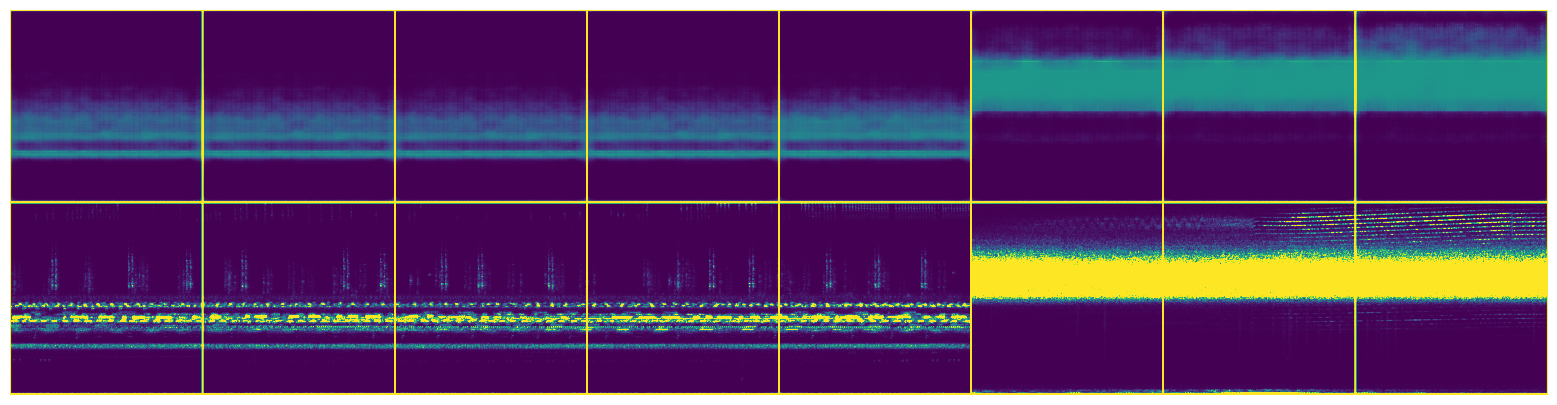

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 201 of 1004 	 loss: 0.4958
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 202 of 1004 	 loss: 0.1656
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 203 of 1004 	 loss: 0.1272
torch.Size

epoch: 1 of 10 	 iteration: 225 of 1004 	 loss: 0.2883
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 226 of 1004 	 loss: 0.3296
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 227 of 1004 	 loss: 0.2088
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 250 of 1004 	 loss: 0.1602
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 251 of 1004 	 loss: 0.3257
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 252 of 1004 	 loss: 0.1658
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 275 of 1004 	 loss: 0.1827
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 276 of 1004 	 loss: 0.4051
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 277 of 1004 	 loss: 0.2528
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 300 of 1004 	 loss: 0.3201
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 301 of 1004 	 loss: 0.1709
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 302 of 1004 	 loss: 0.4171
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 325 of 1004 	 loss: 0.2586
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 326 of 1004 	 loss: 0.2204
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 327 of 1004 	 loss: 0.1691
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 350 of 1004 	 loss: 0.5351
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 351 of 1004 	 loss: 0.2177
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 352 of 1004 	 loss: 0.2441
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 375 of 1004 	 loss: 0.1945
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 376 of 1004 	 loss: 0.1549
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 377 of 1004 	 loss: 0.2017
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 400 of 1004 	 loss: 0.218
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])


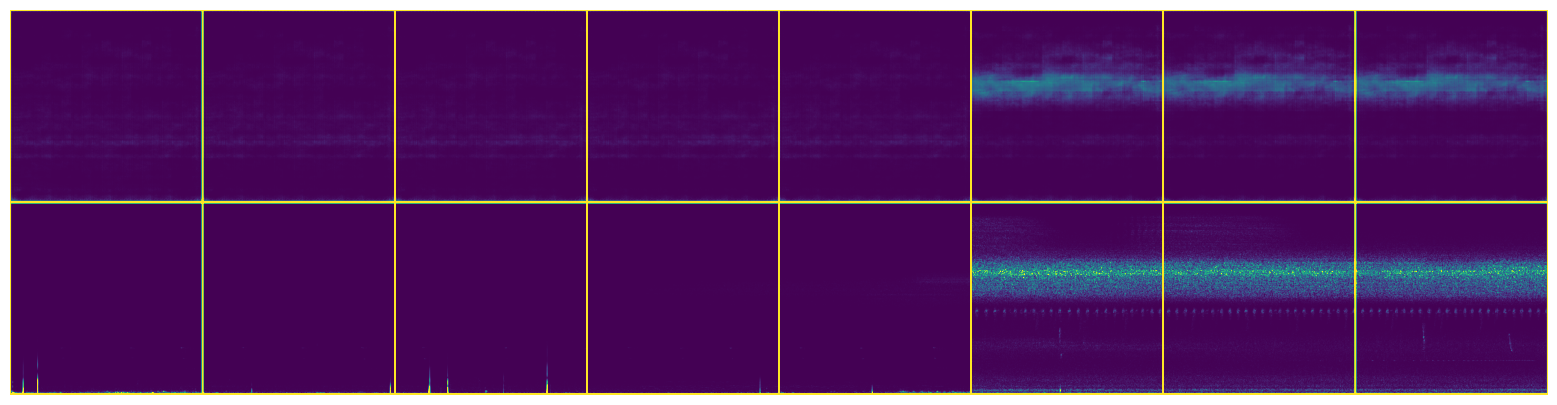

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 401 of 1004 	 loss: 0.166
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 402 of 1004 	 loss: 0.2481
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 403 of 1004 	 loss: 0.1243
torch.Size(

epoch: 1 of 10 	 iteration: 425 of 1004 	 loss: 0.2449
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 426 of 1004 	 loss: 0.1805
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 427 of 1004 	 loss: 0.19
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 

epoch: 1 of 10 	 iteration: 450 of 1004 	 loss: 0.1416
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 451 of 1004 	 loss: 0.3084
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 452 of 1004 	 loss: 0.2646
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 475 of 1004 	 loss: 0.1301
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 476 of 1004 	 loss: 0.2566
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 477 of 1004 	 loss: 0.2542
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 500 of 1004 	 loss: 0.1906
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 501 of 1004 	 loss: 0.2999
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 502 of 1004 	 loss: 0.1576
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 525 of 1004 	 loss: 0.2343
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 526 of 1004 	 loss: 0.1594
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 527 of 1004 	 loss: 0.5802
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 550 of 1004 	 loss: 0.2042
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 551 of 1004 	 loss: 0.1533
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 552 of 1004 	 loss: 0.1545
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 575 of 1004 	 loss: 0.1247
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 576 of 1004 	 loss: 0.1898
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 577 of 1004 	 loss: 0.2033
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 600 of 1004 	 loss: 0.1864
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])


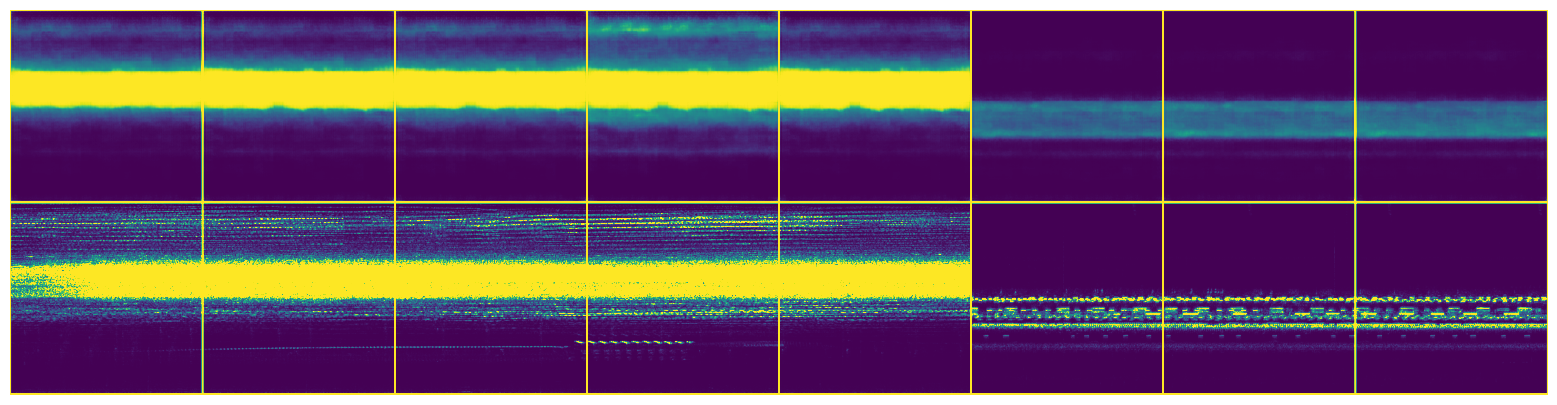

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 601 of 1004 	 loss: 0.1815
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 602 of 1004 	 loss: 0.2069
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 603 of 1004 	 loss: 0.172
torch.Size(

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 626 of 1004 	 loss: 0.1448
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 627 of 1004 	 loss: 0.144
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 628 of 1004 	 loss: 0.2359
torch.Size(

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 651 of 1004 	 loss: 0.2704
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 652 of 1004 	 loss: 0.1846
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 653 of 1004 	 loss: 0.2148
torch.Size

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 676 of 1004 	 loss: 0.3362
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 677 of 1004 	 loss: 0.2423
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 678 of 1004 	 loss: 0.163
torch.Size(

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 701 of 1004 	 loss: 0.1252
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 702 of 1004 	 loss: 0.1432
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 703 of 1004 	 loss: 0.2053
torch.Size

epoch: 1 of 10 	 iteration: 725 of 1004 	 loss: 0.3206
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 726 of 1004 	 loss: 0.1838
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 727 of 1004 	 loss: 0.3131
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 750 of 1004 	 loss: 0.2213
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 751 of 1004 	 loss: 0.1883
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 752 of 1004 	 loss: 0.2514
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 775 of 1004 	 loss: 0.2339
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 776 of 1004 	 loss: 0.2418
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 777 of 1004 	 loss: 0.3884
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 800 of 1004 	 loss: 0.1291
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])


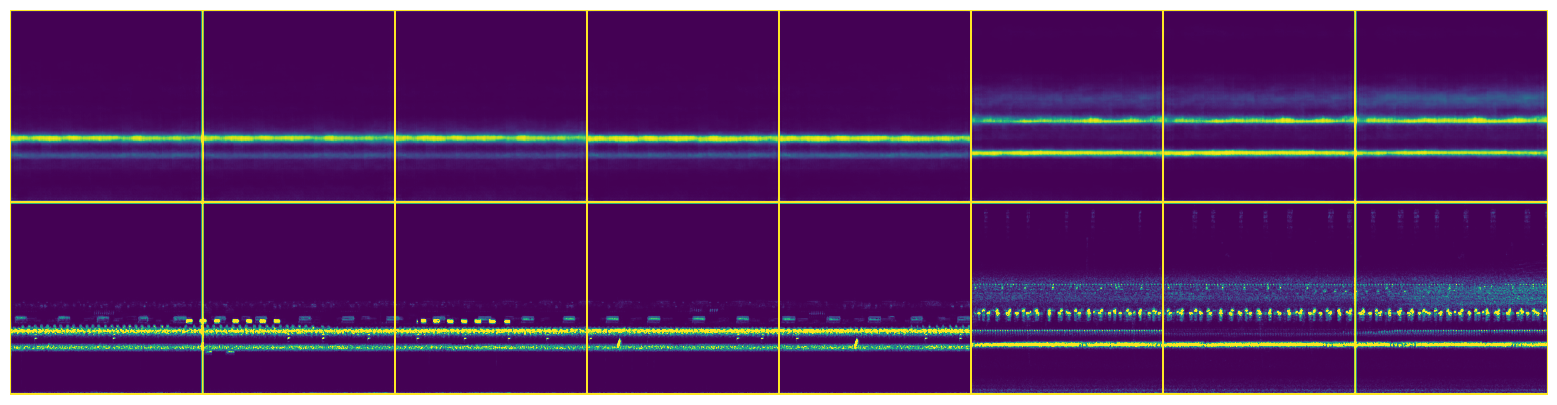

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 801 of 1004 	 loss: 0.1181
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 802 of 1004 	 loss: 0.1734
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 803 of 1004 	 loss: 0.2686
torch.Size

epoch: 1 of 10 	 iteration: 825 of 1004 	 loss: 0.0963
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 826 of 1004 	 loss: 0.1914
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 827 of 1004 	 loss: 0.0938
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 850 of 1004 	 loss: 0.156
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 851 of 1004 	 loss: 0.1528
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 852 of 1004 	 loss: 0.1571
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of

epoch: 1 of 10 	 iteration: 875 of 1004 	 loss: 0.1626
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 876 of 1004 	 loss: 0.0924
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 877 of 1004 	 loss: 0.2219
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 900 of 1004 	 loss: 0.2113
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 901 of 1004 	 loss: 0.1788
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 902 of 1004 	 loss: 0.3572
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 925 of 1004 	 loss: 0.2287
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 926 of 1004 	 loss: 0.3944
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 927 of 1004 	 loss: 0.3031
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 950 of 1004 	 loss: 0.1767
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 951 of 1004 	 loss: 0.2491
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 952 of 1004 	 loss: 0.1689
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 975 of 1004 	 loss: 0.1632
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 976 of 1004 	 loss: 0.1227
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 977 of 1004 	 loss: 0.2019
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 o

epoch: 1 of 10 	 iteration: 1000 of 1004 	 loss: 0.1603
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])


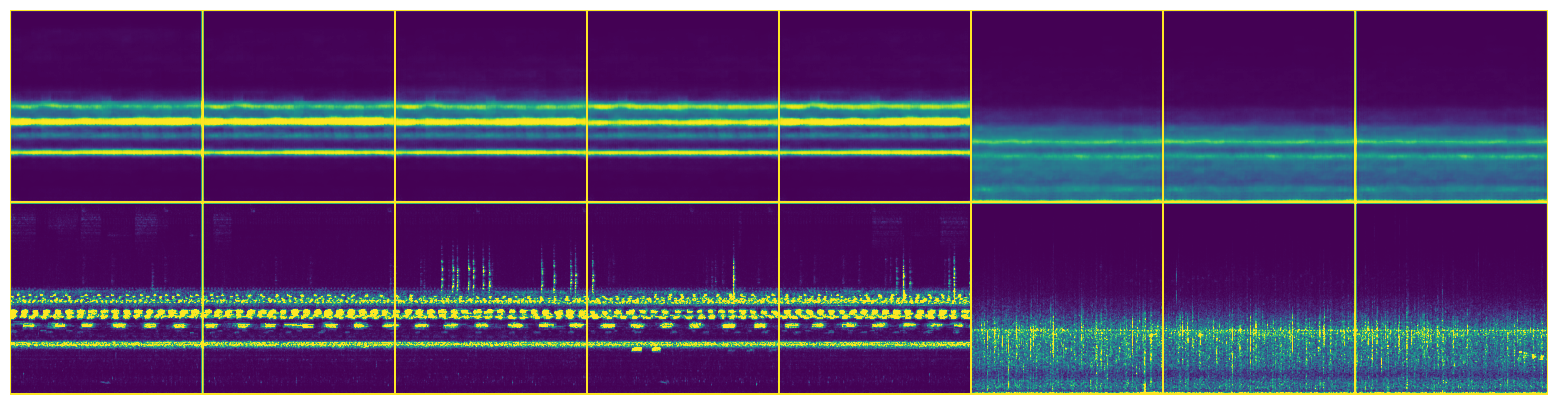

torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 1001 of 1004 	 loss: 0.2033
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 1002 of 1004 	 loss: 0.1047
torch.Size([70, 515, 515])
torch.Size([70, 1, 515, 515])
label: torch.Size([70])
torch.Size([70, 64, 9, 9])
torch.Size([70, 5184])
emb: torch.Size([70, 5184])
torch.Size([70, 5184])
pe torch.Size([70, 5184])
embedding: torch.Size([70, 5184])
view  torch.Size([70, 64, 9, 9])
epoch: 1 of 10 	 iteration: 1003 of 1004 	 loss: 0.2864
torch.S

RuntimeError: The size of tensor a (30) must match the size of tensor b (70) at non-singleton dimension 0

In [6]:
Training = TrainModel(model=model.to("cuda"))
model, logs, run_name = Training.forward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
torch.save(dataset_test, f"temporal/datasets/dataset_test_posae_jaguas_{time.day}_70%.pth")
torch.save(dataset_train, f"temporal/datasets/dataset_train_posae_jaguas_{time.day}_70%.pth")

In [ ]:
iterador = iter(training_loader)
data, b, label, d = next(iterador)
data = torch.reshape(data, (data.shape[0] * data.shape[1] *data.shape[2], data.shape[3], data.shape[4]))
data = torch.unsqueeze(data, 1)
data.shape

In [ ]:
training_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=2)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

In [ ]:
reconstructions[3]

In [ ]:
originals, reconstructions, encodings, loss, label, path = testing.reconstruct()
testing.plot_reconstructions(originals, reconstructions)

In [ ]:
originals, reconstructions, encodings, loss, label, path = testing.reconstruct()

# Featurer

In [ ]:
model_name = f"temporal/models/model_PositionalAE_batch_size_14_num_hiddens_64__day_22_hour_23_final.pth"
config = torch.load(f'temporal/configs/config_PositionalAE_batch_size_14_num_hiddens_64__day_22_hour_23.pth', map_location=torch.device('cpu'))
model = posautoencoding_m1(num_hiddens=config["num_hiddens"]).to("cuda")
dataset_test = torch.load(f'temporal/datasets/dataset_test_posae_jaguas_22_70%.pth')
dataset_train = torch.load(f'temporal/datasets/dataset_train_posae_jaguas_22_70%.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

In [ ]:
from six.moves import xrange
training_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)
iterator = iter(training_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))
encodings_size = encodings[0].shape

training_recorder_list = []
training_hour_list = []
training_minute_list = []
delete_samples = []
training_path_samples = []
training_samples_list_torch = []
for id in range(len(training_loader)):
#     if (id+1)%5 == 0:
#         print("finished")
#         break
    if (id+1)% 500 == 0:
        print(f"id: {id + 1} of {len(dataset_train)}")
    try:
        originals, reconstructions, encodings, label, loss, path = testing.reconstruct()
    except:
        print(f"error id: {id}")
        delete_samples.append(id)
        continue

    encodings_size = encodings[0].shape
    encodings = encodings.to("cuda").detach()
    encodings = encodings.reshape(encodings.shape[0],
                                encodings.shape[1]*encodings.shape[2]*encodings.shape[3])
    encoding = encodings.squeeze(dim=0)
    training_samples_list_torch.append(encodings)
    training_recorder_list.append(label["recorder"].reshape(label["recorder"].shape[0]*label["recorder"].shape[1]))
    training_hour_list.append(label["hour"].reshape(label["hour"].shape[0]*label["hour"].shape[1]))
    training_minute_list.append(label["minute"].reshape(label["minute"].shape[0]*label["minute"].shape[1]))
    
    
    path = np.asarray(path)
    path = np.repeat(path, 5)
    training_path_samples.append(path)

training_recorder_list = torch.cat(training_recorder_list,dim=0)
training_hour_list = torch.cat(training_hour_list,dim=0)
training_minute_list = torch.cat(training_minute_list,dim=0)
training_samples_list_torch = torch.cat(training_samples_list_torch, dim=0)

torch.save(training_path_samples, "Features/train_path_samples_posae.pth")
torch.save(training_samples_list_torch, "Features/train_samples_list_torch_70%_posae.pth")
torch.save(training_recorder_list, "Features/train_recorder_list_70%_posae.pth")
torch.save(training_hour_list, "Features/train_hour_list_70%_posae.pth")
torch.save(training_minute_list, "Features/train_minute_list_70%_posae.pth")
training_labels_list = {"recorder": training_recorder_list, "hour": training_hour_list, "minute": training_minute_list}
torch.save(training_labels_list, "Features/train_labels_list_70%_posae.pth")
torch.save(delete_samples, "Features/train_corrupted_samples_list_70%_posae.pth")

In [ ]:
test = TestModel(model, iterador)

In [ ]:
posenc = PositionalEncoding2d() 
x = posenc(encodes.permute(1,0,2,3), c["recorder"].reshape(14*5))

In [ ]:
posenc = PositionalEncoding2d() 
encodes = model.encoder(data.to("cuda"))
print(encodes.shape)
posencoding_2d = posenc(data, c["recorder"].reshape(14*5))
decoded = model.decoder(posencoding_2d)
